In [1]:
import sys
sys.path.append('C:\\projects\\UTNCE\\src\\utnce202402')

In [2]:
from simplify import *
from prepare import *
from routing import *
from percolation_plot import *
from generate import *
from transfer import *
from copy import deepcopy
from shapely.geometry import Point,LineString
from pyproj import Proj, Transformer
import pickle
import itertools
import random
from sympy import symbols, Eq, solve

In [3]:
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.large.pbf"

# Subway-Amsterdam 

## Generate Baseline network

In [4]:
# Obtain sub-stations in the city
city_sub_stations = sub_stations(osm_path)

In [5]:
# Obtain subway network data
city_sub_network = subway_network(osm_path)

# Prepare the network edges and nodes based on sub-stations and subway network
edges, nodes = prepare_network(city_sub_network, city_sub_stations)

# Expand the edges if required
edges = expand_edges(edges)

# Obtain sub-routes in the city
city_sub_routes = sub_routes(osm_path)

# Sort the sub-routes
city_sub_routes = sorted_routes(city_sub_routes)

# Check the name and assign a column
check_name = check_to_column(city_sub_routes, city_sub_stations)

topology: 100%|████████████████████████████████████████████████████████████████████| 962/962 [00:00<00:00, 8944.37it/s]


In [6]:
# gpd.GeoDataFrame(edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('edges_0408.GPKG',driver='GPKG')

In [7]:
id_nodes_length_sub = len(nodes)
id_edges_length_sub = len(edges)

In [8]:
city_sub_edges = pd.DataFrame(edges.copy())
city_sub_nodes = pd.DataFrame(nodes.copy())

In [9]:
# delete 3 pairs useless and wrong edges 
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 771) & (city_sub_edges['to_id'] == 761)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 771) & (city_sub_edges['to_id'] == 766)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 762) & (city_sub_edges['to_id'] == 771)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 767) & (city_sub_edges['to_id'] == 771)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 780) & (city_sub_edges['to_id'] == 773)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 780) & (city_sub_edges['to_id'] == 772)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 774) & (city_sub_edges['to_id'] == 780)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 775) & (city_sub_edges['to_id'] == 780)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 180) & (city_sub_edges['to_id'] == 345)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 491) & (city_sub_edges['to_id'] == 492)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 498) & (city_sub_edges['to_id'] == 499)].index, inplace=True)



city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 634) & (city_sub_edges['to_id'] == 635)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 654) & (city_sub_edges['to_id'] == 655)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 584) & (city_sub_edges['to_id'] == 585)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 569) & (city_sub_edges['to_id'] == 570)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 588) & (city_sub_edges['to_id'] == 589)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 577) & (city_sub_edges['to_id'] == 589)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 607) & (city_sub_edges['to_id'] == 577)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 564) & (city_sub_edges['to_id'] == 565)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 586) & (city_sub_edges['to_id'] == 587)].index, inplace=True)

city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 643) & (city_sub_edges['to_id'] == 644)].index, inplace=True)
city_sub_edges.drop(city_sub_edges[(city_sub_edges['from_id'] == 638) & (city_sub_edges['to_id'] == 639)].index, inplace=True)

city_sub_edges = city_sub_edges.reset_index(drop = True)

In [10]:
# revise Zuid metro stations' coordinates, replace 712 with 180 and 345 nodes to avoid wrong shortest-path edges
geometry_value1 = city_sub_nodes.loc[city_sub_nodes['id'] == 180, 'geometry'].values[0]
geometry_value2 = city_sub_nodes.loc[city_sub_nodes['id'] == 345, 'geometry'].values[0]

city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geometry'] = geometry_value1
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geo_x'] = geometry_value1.x
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737797', 'geo_y'] = geometry_value1.y

city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geometry'] = geometry_value2
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geo_x'] = geometry_value2.x
city_sub_stations.loc[city_sub_stations['osm_id'] == '4073737796', 'geo_y'] = geometry_value2.y

In [11]:
replacement_dict = {
     'Amsterdam Centraal': 'Centraal Station',
}

In [12]:
# Replace values in the 'to' column of the metro routes using the replacement dictionary
city_sub_routes['to'] = city_sub_routes['to'].replace(replacement_dict, regex=True).str.strip()

# Reset the index of the metro routes
city_sub_routes = city_sub_routes.reset_index(drop=True)

# Check if the values in the 'to' column of the metro routes match the station names
check_name = check_to_column(city_sub_routes, city_sub_stations)

In [13]:
# gpd.GeoDataFrame(city_sub_edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('city_sub_edges_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(city_sub_stations[['osm_id', 'geometry','name']]).to_file('city_sub_stations_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(city_sub_nodes[['geometry','degree','id']]).to_file('city_sub_nodes_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(city_sub_routes[['osm_id', 'route', 'name', 'geometry']]).to_file('city_sub_routes_0417.GPKG',driver='GPKG')

In [14]:
# # 将DataFrame保存为pickle文件
# city_sub_edges.to_pickle('city_sub_edges_0328.pkl')
# city_sub_stations.to_pickle('city_sub_stations_0328.pkl')
# city_sub_nodes.to_pickle('city_sub_nodes_0328.pkl')
# city_sub_routes.to_pickle('city_sub_routes_0328.pkl')

In [15]:
# Create a dictionary mapping start stations to their corresponding routes
city_sub_start_station_name_dict = start_station_dict(city_sub_routes)

# Create a dictionary mapping subway lines to their corresponding routes
city_sub_line_dict = line_dict(city_sub_routes)

# Create a list of all station names in the city's subway network
city_all_sub_stations_name = all_station_list(city_sub_stations)

# Create a dictionary mapping subway lines to the ordered list of stations on each line
city_sub_order_route_dict = order_stations_inline(city_sub_line_dict, city_all_sub_stations_name, city_sub_routes, city_sub_start_station_name_dict)

In [16]:
# revise station sequence of 51_1 route
df51_1 = pd.read_excel('C:\\projects\\UTNCE\\data\\Metro 51 Centraal Station = Isolatorweg.xlsx',header=None)
df51_1 = df51_1[0::4].reset_index(drop=True)
df51_1.columns = ['name']
df51_1.name[9] = 'Zuid' 
df51_1.name[13] = 'Lelylaan' 
df51_1.name[16] = 'De Vlugtlaan' 

df = city_sub_order_route_dict['Metro 51: Centraal Station => Isolatorweg']
df_reordered = pd.merge(df51_1,df,on='name')

desired_order = ['id', 'name', 'geometry', 'geo_x', 'geo_y']
df_reordered = df_reordered[desired_order]

key_to_replace = 'Metro 51: Centraal Station => Isolatorweg'
city_sub_order_route_dict[key_to_replace] = df_reordered

# city_sub_order_route_dict

In [17]:
df52_metro_1 = city_sub_order_route_dict['Metro 52: Noord => Zuid']
df52_metro_2 = city_sub_order_route_dict['Metro 52: Zuid => Noord']

df52_metro_1_dep = df52_metro_1[df52_metro_1.name == 'De Pijp'].copy()
df52_metro_2_dep = df52_metro_2[df52_metro_2.name == 'De Pijp'].copy()


columns_to_swap = ['geometry', 'geo_x', 'geo_y']
for column in columns_to_swap:
    temp = df52_metro_1_dep[column].copy()
    df52_metro_1_dep.loc[df52_metro_1_dep['name'] == 'De Pijp', column] = df52_metro_2_dep.loc[df52_metro_2_dep['name'] == 'De Pijp', column].values
    df52_metro_2_dep.loc[df52_metro_2_dep['name'] == 'De Pijp', column] = temp.values

df52_metro_1.loc[df52_metro_1['name'] == 'De Pijp', columns_to_swap] = df52_metro_1_dep[columns_to_swap].values
df52_metro_2.loc[df52_metro_2['name'] == 'De Pijp', columns_to_swap] = df52_metro_2_dep[columns_to_swap].values

# city_sub_order_route_dict

In [18]:
# Create a dictionary mapping subway lines to the pairs of station IDs on each line
city_sub_order_id_pairs = id_pairs_inline(city_sub_line_dict, city_sub_order_route_dict, city_sub_nodes)

In [19]:
# Create a graph representing the subway network using the extracted edges and nodes
G = create_ground_graph(city_sub_edges, city_sub_nodes)

# Calculate the shortest path id pairs for each subway line

city_sub_all_shortest_paths_id_dict = city_sub_order_id_pairs.copy()


for line in city_sub_order_id_pairs.keys():
    # Calculate all shortest paths id for the current line using the subway network edges
    city_sub_all_shortest_paths_id_dict[line] = all_shortest_path_id_list(G, city_sub_order_id_pairs[line], city_sub_edges)

In [20]:
# city_sub_all_shortest_paths_id_dict

In [21]:
city_sub_ordered_edges = edges_revise_direction(city_sub_all_shortest_paths_id_dict,city_sub_edges)
city_sub_ordered_edges

,from_id,to_id,osm_id,geometry,railway,service,id,distance,time,weights,from_to,to_from
0,1,0,23157994,"LINESTRING (4.9236699 52.3361909, 4.9236979 52...",subway,None,0,258.660599,0.010346,258,"(1, 0)","(0, 1)"
1,2,3,23158053,"LINESTRING (4.9642294 52.2945339, 4.9644259 52...",subway,None,1,215.433271,0.008617,215,"(2, 3)","(3, 2)"
2,4,5,23158054,"LINESTRING (4.9622901 52.2955678, 4.9624673 52...",subway,None,2,121.794737,0.004872,121,"(4, 5)","(5, 4)"
3,7,6,23189033,"LINESTRING (4.8467318 52.3952137, 4.8471439 52...",subway,None,3,28.046592,0.001122,28,"(7, 6)","(6, 7)"
4,492,8,23189039,"LINESTRING (4.8409161 52.3937679, 4.8416087 52...",subway,None,4,382.935219,0.015317,382,"(492, 8)","(8, 492)"
...,...,...,...,...,...,...,...,...,...,...,...,...
935,803,463,1131538381,"LINESTRING (4.9200955 52.3417374, 4.9200444 52...",subway,None,957,73.656989,0.002946,73,"(803, 463)","(463, 803)"
936,462,803,1131538382,"LINESTRING (4.9201445 52.3416568, 4.9200955 52...",subway,None,958,9.568427,0.000383,9,"(462, 803)","(803, 462)"
937,246,804,1131538383,"LINESTRING (4.9200365 52.3417239, 4.9200773 52...",subway,None,959,9.568874,0.000383,9,"(246, 804)","(804, 246)"
938,804,463,1131538384,"LINESTRING (4.9197172 52.3423576, 4.9197589 52...",subway,None,960,73.789113,0.002952,73,"(804, 463)","(463, 804)"


In [22]:
# Extract the edges from the input DataFrame and create a list of tuples with time
od = city_sub_ordered_edges[['from_id', 'to_id', 'time']]
edges_list = []
for i, row in od.iterrows():
    weight_dict = {"weight": row[2]*60}
    tuple_row = (row[0], row[1], weight_dict)
    edges_list.append(tuple_row)
# edges_list

In [23]:
G = nx.DiGraph()
for _, row in city_sub_nodes.iterrows():
    node = row['id']  # Assuming 'id' is the node identifier
    geometry = row['geometry']
    x, y = geometry.x, geometry.y
    G.add_node(node, pos=(x, y))
G.add_edges_from(edges_list)

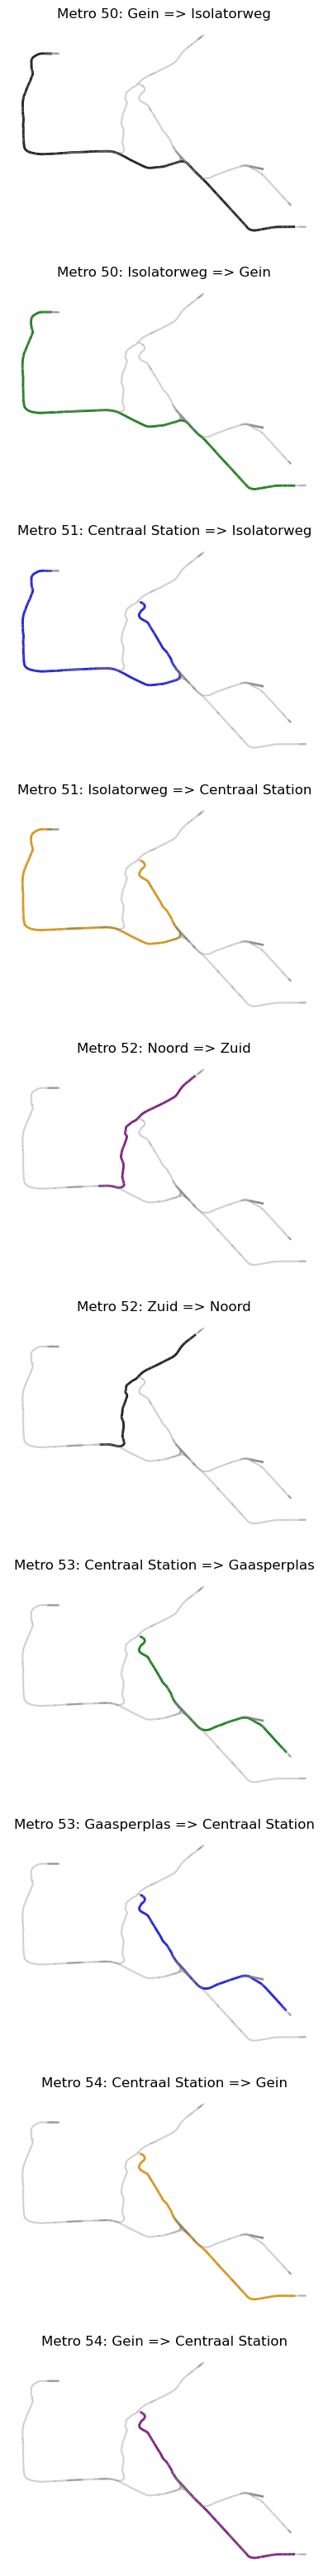

In [24]:
# Calculate the shortest path pairs for each subway line
city_sub_shortest_path_pairs_dict = city_sub_order_id_pairs.copy()
duplicate_row_count = city_sub_order_id_pairs.copy()
city_sub_shortest_path_edges_dict = city_sub_order_id_pairs.copy()
city_sub_edges_dict = city_sub_order_id_pairs.copy()

for line in city_sub_order_id_pairs.keys():
    # Calculate all shortest paths for the current line using the subway network edges
    city_sub_shortest_path_pairs_dict[line] = all_shortest_paths(G, city_sub_order_id_pairs[line], city_sub_ordered_edges)

    # Count the duplicate rows, calculate the weighted edges for shortest paths,
    # and update the subway network edges for the current line
    duplicate_row_count[line], city_sub_shortest_path_edges_dict[line], city_sub_edges_dict[line] = edges_with_count_weight(city_sub_shortest_path_pairs_dict[line], city_sub_ordered_edges)
    
# Plot all subway routes
plot_routes(city_sub_routes, city_sub_ordered_edges, city_sub_shortest_path_edges_dict)

In [25]:
# df50_1 = city_sub_shortest_path_edges_dict['Metro 50: Gein => Isolatorweg']
# df50_2 = city_sub_shortest_path_edges_dict['Metro 50: Isolatorweg => Gein']

# df51_1 = city_sub_shortest_path_edges_dict['Metro 51: Centraal Station => Isolatorweg']
# df51_2 = city_sub_shortest_path_edges_dict['Metro 51: Isolatorweg => Centraal Station']

# df52_1 = city_sub_shortest_path_edges_dict['Metro 52: Noord => Zuid'] 
# df52_2 = city_sub_shortest_path_edges_dict['Metro 52: Zuid => Noord']

# df53_1 = city_sub_shortest_path_edges_dict['Metro 53: Centraal Station => Gaasperplas']
# df53_2 = city_sub_shortest_path_edges_dict['Metro 53: Gaasperplas => Centraal Station']

# df54_1 = city_sub_shortest_path_edges_dict['Metro 54: Centraal Station => Gein']
# df54_2 = city_sub_shortest_path_edges_dict['Metro 54: Gein => Centraal Station']

In [26]:
# gpd.GeoDataFrame(df50_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df50_1_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df50_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df50_2_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df51_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df51_1_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df51_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df51_2_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df52_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df52_1_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df52_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df52_2_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df53_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df53_1_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df53_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df53_2_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df54_1[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df54_1_0417.GPKG',driver='GPKG')
# gpd.GeoDataFrame(df54_2[['osm_id', 'geometry','id','from_id','to_id','distance','time','weights']]).to_file('df54_2_0417.GPKG',driver='GPKG')

### Add columns to edges--city_sub_extended_edges

In [27]:
city_sub_shortest_path_edges_dict

{'Metro 50: Gein => Isolatorweg':      from_id  to_id     osm_id  \
 0        634    317  166187911   
 1        318    634  166187911   
 2        321    318  166187913   
 3        654    321  166187917   
 4        328    654  166187917   
 ..       ...    ...        ...   
 158      491    373  166370272   
 159      374    498  166370274   
 160      498     79  166370274   
 161      373    374  166370275   
 162      121    372  166370277   
 
                                               geometry railway service   id  \
 0    LINESTRING (4.9823107 52.2963387, 4.9838859 52...  subway    None  358   
 1    LINESTRING (4.9838859 52.2963361, 4.9847396 52...  subway    None  359   
 2    LINESTRING (4.9847396 52.2963405, 4.9850507 52...  subway    None  361   
 3    LINESTRING (4.9850507 52.2963421, 4.9856334 52...  subway    None  366   
 4    LINESTRING (4.9871059 52.2963808, 4.9873266 52...  subway    None  367   
 ..                                                 ...     ...  

In [28]:
city_sub_shortest_path_edges = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_shortest_path_edges_dict, city_sub_routes)

In [29]:
city_sub_extended_edges = add_columns_to_edges(city_sub_shortest_path_edges_dict,city_sub_ordered_edges)

In [30]:
column_to_drop = 'count_weight'
city_sub_extended_edges = city_sub_extended_edges.drop(columns=column_to_drop)

In [31]:
city_sub_extended_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,route_name_list,route,ref
0,23157994,"LINESTRING (4.9236699 52.3361909, 4.9236979 52...",subway,None,0,1,0,258.660599,0.010346,258,"(0, 1)","(1, 0)",Metro 51: Isolatorweg => Centraal Station,subway,51
1,23158053,"LINESTRING (4.9642294 52.2945339, 4.9644259 52...",subway,None,1,2,3,215.433271,0.008617,215,"(3, 2)","(2, 3)",Metro 50: Isolatorweg => Gein,subway,"50, 54"
2,23158054,"LINESTRING (4.9622901 52.2955678, 4.9624673 52...",subway,None,2,4,5,121.794737,0.004872,121,"(5, 4)","(4, 5)",Metro 50: Isolatorweg => Gein,subway,"50, 54"
3,23189033,"LINESTRING (4.8467318 52.3952137, 4.8471439 52...",subway,None,3,7,6,28.046592,0.001122,28,"(6, 7)","(7, 6)",Metro 50: Isolatorweg => Gein,subway,"50, 51"
4,23189039,"LINESTRING (4.8409161 52.3937679, 4.8416087 52...",subway,None,4,492,8,382.935219,0.015317,382,"(8, 492)","(492, 8)",Metro 50: Isolatorweg => Gein,subway,"50, 51"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,1131538381,"LINESTRING (4.9200955 52.3417374, 4.9200444 52...",subway,None,957,803,463,73.656989,0.002946,73,"(463, 803)","(803, 463)",Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
936,1131538382,"LINESTRING (4.9201445 52.3416568, 4.9200955 52...",subway,None,958,462,803,9.568427,0.000383,9,"(803, 462)","(462, 803)",Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
937,1131538383,"LINESTRING (4.9200365 52.3417239, 4.9200773 52...",subway,None,959,246,804,9.568874,0.000383,9,"(804, 246)","(246, 804)",Metro 51: Isolatorweg => Centraal Station,subway,51
938,1131538384,"LINESTRING (4.9197172 52.3423576, 4.9197589 52...",subway,None,960,804,463,73.789113,0.002952,73,"(463, 804)","(804, 463)",Metro 51: Isolatorweg => Centraal Station,subway,51


### Organize edges dataframe for baseline network--city_sub_new_edges

In [32]:
city_sub_shortest_path_edges_df = pd.concat(city_sub_shortest_path_edges_dict.values()).reset_index(drop=True)
city_sub_shortest_path_edges_df.drop_duplicates(subset='geometry',inplace=True,ignore_index=True)
city_sub_shortest_path_edges_df

,from_id,to_id,osm_id,geometry,railway,service,id,distance,time,weights,from_to,to_from,count_weight,route_name_list,ref,route
0,634,317,166187911,"LINESTRING (4.9823107 52.2963387, 4.9838859 52...",subway,None,358,107.447350,0.004298,107,"(634, 317)","(317, 634)",1.0,Metro 50: Gein => Isolatorweg,50,subway
1,318,634,166187911,"LINESTRING (4.9838859 52.2963361, 4.9847396 52...",subway,None,359,58.234342,0.002329,58,"(318, 634)","(634, 318)",1.0,Metro 50: Gein => Isolatorweg,50,subway
2,321,318,166187913,"LINESTRING (4.9847396 52.2963405, 4.9850507 52...",subway,None,361,21.221392,0.000849,21,"(321, 318)","(318, 321)",1.0,Metro 50: Gein => Isolatorweg,50,subway
3,654,321,166187917,"LINESTRING (4.9850507 52.2963421, 4.9856334 52...",subway,None,366,140.268473,0.005611,140,"(654, 321)","(321, 654)",1.0,Metro 50: Gein => Isolatorweg,50,subway
4,328,654,166187917,"LINESTRING (4.9871059 52.2963808, 4.9873266 52...",subway,None,367,140.227871,0.005609,140,"(328, 654)","(654, 328)",1.0,Metro 50: Gein => Isolatorweg,50,subway
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,799,274,1061085953,"LINESTRING (4.9221322 52.3381876, 4.921962 52....",subway,None,951,26.073700,0.001043,26,"(799, 274)","(274, 799)",1.0,Metro 54: Centraal Station => Gein,54,subway
632,241,258,166133730,"LINESTRING (4.9292423 52.3310966, 4.9286644 52...",subway,None,285,79.981699,0.003199,79,"(241, 258)","(258, 241)",1.0,Metro 54: Gein => Centraal Station,54,subway
633,258,275,166134298,"LINESTRING (4.9286644 52.3317223, 4.927832 52....",subway,None,305,115.819483,0.004633,115,"(258, 275)","(275, 258)",1.0,Metro 54: Gein => Centraal Station,54,subway
634,275,696,503528039,"LINESTRING (4.927832 52.3326299, 4.926833 52.3...",subway,None,756,139.091384,0.005564,139,"(275, 696)","(696, 275)",1.0,Metro 54: Gein => Centraal Station,54,subway


In [33]:
city_sub_new_edges = pd.merge(city_sub_extended_edges,city_sub_shortest_path_edges_df.geometry,on='geometry',how='inner')
city_sub_new_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,route_name_list,route,ref
0,23157994,"LINESTRING (4.9236699 52.3361909, 4.9236979 52...",subway,None,0,1,0,258.660599,0.010346,258,"(0, 1)","(1, 0)",Metro 51: Isolatorweg => Centraal Station,subway,51
1,23158053,"LINESTRING (4.9642294 52.2945339, 4.9644259 52...",subway,None,1,2,3,215.433271,0.008617,215,"(3, 2)","(2, 3)",Metro 50: Isolatorweg => Gein,subway,"50, 54"
2,23158054,"LINESTRING (4.9622901 52.2955678, 4.9624673 52...",subway,None,2,4,5,121.794737,0.004872,121,"(5, 4)","(4, 5)",Metro 50: Isolatorweg => Gein,subway,"50, 54"
3,23189033,"LINESTRING (4.8467318 52.3952137, 4.8471439 52...",subway,None,3,7,6,28.046592,0.001122,28,"(6, 7)","(7, 6)",Metro 50: Isolatorweg => Gein,subway,"50, 51"
4,23189039,"LINESTRING (4.8409161 52.3937679, 4.8416087 52...",subway,None,4,492,8,382.935219,0.015317,382,"(8, 492)","(492, 8)",Metro 50: Isolatorweg => Gein,subway,"50, 51"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,1131538381,"LINESTRING (4.9200955 52.3417374, 4.9200444 52...",subway,None,957,803,463,73.656989,0.002946,73,"(463, 803)","(803, 463)",Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
632,1131538382,"LINESTRING (4.9201445 52.3416568, 4.9200955 52...",subway,None,958,462,803,9.568427,0.000383,9,"(803, 462)","(462, 803)",Metro 53: Gaasperplas => Centraal Station,subway,"53, 54"
633,1131538383,"LINESTRING (4.9200365 52.3417239, 4.9200773 52...",subway,None,959,246,804,9.568874,0.000383,9,"(804, 246)","(246, 804)",Metro 51: Isolatorweg => Centraal Station,subway,51
634,1131538384,"LINESTRING (4.9197172 52.3423576, 4.9197589 52...",subway,None,960,804,463,73.789113,0.002952,73,"(463, 804)","(804, 463)",Metro 51: Isolatorweg => Centraal Station,subway,51


In [34]:
gpd.GeoDataFrame(city_sub_new_edges[['osm_id', 'geometry', 'id', 'from_id', 'to_id', 'distance', 'time', 'weights']]).to_file('city_sub_new_edges_0418.GPKG',driver='GPKG')

### Organize nodes dataframe for baseline network--city_sub_new_nodes

In [35]:
city_sub_shortest_path_nodes_id = pd.DataFrame(list(city_sub_new_edges['from_id'])+list(city_sub_new_edges['to_id'])).drop_duplicates(ignore_index = True)

In [36]:
city_sub_shortest_path_nodes_id = city_sub_shortest_path_nodes_id.rename(columns={0:'id'})

In [37]:
city_sub_shortest_path_nodes_id

,id
0,1
1,2
2,4
3,7
4,492
...,...
633,805
634,323
635,180
636,728


In [38]:
city_sub_new_nodes = pd.merge(city_sub_shortest_path_nodes_id,city_sub_nodes,on='id',how='left').reset_index(drop=True)
city_sub_new_nodes

,id,geometry,degree
0,1,POINT (4.9232197 52.3339159),2
1,2,POINT (4.9642294 52.2945339),2
2,4,POINT (4.9622901 52.2955678),2
3,7,POINT (4.8471439 52.3952143),2
4,492,POINT (4.8457805 52.395217),3
...,...,...,...
633,805,POINT (4.8505958 52.3951031),2
634,323,POINT (4.989299 52.2962711),2
635,180,POINT (4.8772326 52.3393181),3
636,728,POINT (4.9010471 52.3775081),2


### Add columns to stations--city_sub_new_staions

In [39]:
city_sub_order_route_dict = add_ref_to_orderroutes_or_shortestpath_dict(city_sub_order_route_dict, city_sub_routes)

In [40]:
city_sub_new_stations = add_columns_to_nodes(city_sub_order_route_dict, city_sub_new_nodes)

In [41]:
city_sub_new_stations

,id,geometry,degree,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,328,POINT (4.98916 52.29641),2,Gein,4.989161,52.296407,"(4.9891612, 52.2964067)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
1,855,POINT (4.97400 52.29564),2,Reigersbos,4.974000,52.295637,"(4.9740002, 52.2956365)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
2,854,POINT (4.96013 52.29813),2,Holendrecht,4.960126,52.298132,"(4.9601264, 52.2981319)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
3,810,POINT (4.95213 52.30687),2,Bullewijk,4.952129,52.306869,"(4.9521292, 52.306869)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
4,809,POINT (4.94762 52.31181),2,Bijlmer ArenA,4.947618,52.311806,"(4.9476178, 52.311806)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
...,...,...,...,...,...,...,...,...,...,...,...
82,824,POINT (4.96734 52.32837),2,Verrijn Stuartweg,4.967335,52.328367,"(4.9673352, 52.3283668)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
83,823,POINT (4.95669 52.33041),2,Station Diemen Zuid,4.956688,52.330406,"(4.9566878, 52.3304057)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
84,829,POINT (4.94628 52.32683),2,Venserpolder,4.946277,52.326833,"(4.9462773, 52.3268326)",Metro 53: Gaasperplas => Centraal Station,subway,53,None
85,827,POINT (4.93028 52.32974),2,Van der Madeweg,4.930285,52.329735,"(4.9302846, 52.3297352)",Metro 53: Gaasperplas => Centraal Station,subway,"50, 53, 54","50, 53, 54"


## Create virtual edges at Central station/on single network 

### Only connect Centraal Station

In [59]:
def connect_edges_one_network(connect_stations,id_edges_length_sub,city_sub_new_edges):
    
    id_list = list(connect_stations['id'])
    id_pairs_list = list(permutations(id_list, 2))

    connect_station_coordinate_list = list(connect_stations['coordinate_value'])
    line_segments = []
    for pair in permutations(connect_station_coordinate_list, 2):
        line_segments.append(LineString(pair))

    connect_edges = pd.DataFrame({
                'from_id':[pair[0] for pair in id_pairs_list], 
                'to_id':[pair[1] for pair in id_pairs_list], 
                'from_to': id_pairs_list, 
                'to_from': [(pair[1], pair[0])for pair in id_pairs_list],            
                'geometry': line_segments})

    connect_edges_id_list = [id_edges_length_sub] + [i for i in range(id_edges_length_sub+1, id_edges_length_sub+len(connect_edges))]
    connect_edges['id'] = connect_edges_id_list
    connect_edges['weights'] = city_sub_new_edges.sort_values(by = 'distance').weights.iloc[-1] + 1
    return connect_edges

In [60]:
connect_stations_df1 = city_sub_new_stations[city_sub_new_stations['name'] == 'Centraal Station']
connect_edges1 = connect_edges_one_network(connect_stations_df1,id_edges_length_sub,city_sub_new_edges)
connect_edges1

,from_id,to_id,from_to,to_from,geometry,id,weights
0,731,728,"(731, 728)","(728, 731)","LINESTRING (4.9008686 52.3773546, 4.9010471 52...",962,1111
1,731,816,"(731, 816)","(816, 731)","LINESTRING (4.9008686 52.3773546, 4.9008785 52...",963,1111
2,731,815,"(731, 815)","(815, 731)","LINESTRING (4.9008686 52.3773546, 4.9009371 52...",964,1111
3,728,731,"(728, 731)","(731, 728)","LINESTRING (4.9010471 52.3775081, 4.9008686 52...",965,1111
4,728,816,"(728, 816)","(816, 728)","LINESTRING (4.9010471 52.3775081, 4.9008785 52...",966,1111
5,728,815,"(728, 815)","(815, 728)","LINESTRING (4.9010471 52.3775081, 4.9009371 52...",967,1111
6,816,731,"(816, 731)","(731, 816)","LINESTRING (4.9008785 52.3792082, 4.9008686 52...",968,1111
7,816,728,"(816, 728)","(728, 816)","LINESTRING (4.9008785 52.3792082, 4.9010471 52...",969,1111
8,816,815,"(816, 815)","(815, 816)","LINESTRING (4.9008785 52.3792082, 4.9009371 52...",970,1111
9,815,731,"(815, 731)","(731, 815)","LINESTRING (4.9009371 52.3791884, 4.9008686 52...",971,1111


In [61]:
connect_stations_df2 = city_sub_new_stations[city_sub_new_stations['name'] == 'Zuid']
connect_stations_df2

,id,geometry,degree,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
10,840,POINT (4.87396 52.33932),2,Zuid,4.873963,52.339322,"(4.8739633, 52.3393223)",Metro 50: Gein => Isolatorweg,subway,"50, 51, 52","50, 51, 52"
29,83,POINT (4.87398 52.33904),2,Zuid,4.873978,52.339035,"(4.8739781, 52.3390351)",Metro 50: Isolatorweg => Gein,subway,"50, 51, 52","50, 51, 52"
62,180,POINT (4.87723 52.33932),3,Zuid,4.877233,52.339318,"(4.8772326, 52.3393181)",Metro 52: Noord => Zuid,subway,"50, 51, 52","50, 51, 52"
63,345,POINT (4.87802 52.33930),2,Zuid,4.878025,52.339303,"(4.8780248, 52.3393025)",Metro 52: Zuid => Noord,subway,"50, 51, 52","50, 51, 52"


In [63]:
connect_edges2 = connect_edges_one_network(connect_stations_df2,id_edges_length_sub+len(connect_edges1),city_sub_new_edges)
connect_edges2

,from_id,to_id,from_to,to_from,geometry,id,weights
0,840,83,"(840, 83)","(83, 840)","LINESTRING (4.8739633 52.3393223, 4.8739781 52...",974,1111
1,840,180,"(840, 180)","(180, 840)","LINESTRING (4.8739633 52.3393223, 4.8772326 52...",975,1111
2,840,345,"(840, 345)","(345, 840)","LINESTRING (4.8739633 52.3393223, 4.8780248 52...",976,1111
3,83,840,"(83, 840)","(840, 83)","LINESTRING (4.8739781 52.3390351, 4.8739633 52...",977,1111
4,83,180,"(83, 180)","(180, 83)","LINESTRING (4.8739781 52.3390351, 4.8772326 52...",978,1111
5,83,345,"(83, 345)","(345, 83)","LINESTRING (4.8739781 52.3390351, 4.8780248 52...",979,1111
6,180,840,"(180, 840)","(840, 180)","LINESTRING (4.8772326 52.3393181, 4.8739633 52...",980,1111
7,180,83,"(180, 83)","(83, 180)","LINESTRING (4.8772326 52.3393181, 4.8739781 52...",981,1111
8,180,345,"(180, 345)","(345, 180)","LINESTRING (4.8772326 52.3393181, 4.8780248 52...",982,1111
9,345,840,"(345, 840)","(840, 345)","LINESTRING (4.8780248 52.3393025, 4.8739633 52...",983,1111


In [65]:
city_sub_connected_edges = pd.concat([city_sub_new_edges, connect_edges1, connect_edges2])
city_sub_connected_edges

,osm_id,geometry,railway,service,id,from_id,to_id,distance,time,weights,to_from,from_to,route_name_list,route,ref
0,23157994,"LINESTRING (4.9236699 52.3361909, 4.9236979 52...",subway,None,0,1,0,258.660599,0.010346,258,"(0, 1)","(1, 0)",Metro 51: Isolatorweg => Centraal Station,subway,51
1,23158053,"LINESTRING (4.9642294 52.2945339, 4.9644259 52...",subway,None,1,2,3,215.433271,0.008617,215,"(3, 2)","(2, 3)",Metro 50: Isolatorweg => Gein,subway,"50, 54"
2,23158054,"LINESTRING (4.9622901 52.2955678, 4.9624673 52...",subway,None,2,4,5,121.794737,0.004872,121,"(5, 4)","(4, 5)",Metro 50: Isolatorweg => Gein,subway,"50, 54"
3,23189033,"LINESTRING (4.8467318 52.3952137, 4.8471439 52...",subway,None,3,7,6,28.046592,0.001122,28,"(6, 7)","(7, 6)",Metro 50: Isolatorweg => Gein,subway,"50, 51"
4,23189039,"LINESTRING (4.8409161 52.3937679, 4.8416087 52...",subway,None,4,492,8,382.935219,0.015317,382,"(8, 492)","(492, 8)",Metro 50: Isolatorweg => Gein,subway,"50, 51"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,NaN,"LINESTRING (4.8772326 52.3393181, 4.8739781 52...",NaN,NaN,981,180,83,NaN,NaN,1111,"(83, 180)","(180, 83)",NaN,NaN,NaN
8,NaN,"LINESTRING (4.8772326 52.3393181, 4.8780248 52...",NaN,NaN,982,180,345,NaN,NaN,1111,"(345, 180)","(180, 345)",NaN,NaN,NaN
9,NaN,"LINESTRING (4.8780248 52.3393025, 4.8739633 52...",NaN,NaN,983,345,840,NaN,NaN,1111,"(840, 345)","(345, 840)",NaN,NaN,NaN
10,NaN,"LINESTRING (4.8780248 52.3393025, 4.8739781 52...",NaN,NaN,984,345,83,NaN,NaN,1111,"(83, 345)","(345, 83)",NaN,NaN,NaN


### Select nodes where need to build virtual edges based on name

In [50]:
city_sub_transfer_stations = city_sub_new_stations[city_sub_new_stations['transfer'].notna()]

In [51]:
city_sub_transfer_stations

,id,geometry,degree,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
0,328,POINT (4.98916 52.29641),2,Gein,4.989161,52.296407,"(4.9891612, 52.2964067)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
1,855,POINT (4.97400 52.29564),2,Reigersbos,4.974000,52.295637,"(4.9740002, 52.2956365)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
2,854,POINT (4.96013 52.29813),2,Holendrecht,4.960126,52.298132,"(4.9601264, 52.2981319)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
3,810,POINT (4.95213 52.30687),2,Bullewijk,4.952129,52.306869,"(4.9521292, 52.306869)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
4,809,POINT (4.94762 52.31181),2,Bijlmer ArenA,4.947618,52.311806,"(4.9476178, 52.311806)",Metro 50: Gein => Isolatorweg,subway,"50, 54","50, 54"
...,...,...,...,...,...,...,...,...,...,...,...
68,815,POINT (4.90094 52.37919),2,Centraal Station,4.900937,52.379188,"(4.9009371, 52.3791884)",Metro 52: Zuid => Noord,subway,"51, 52, 53, 54","51, 52, 53, 54"
71,830,POINT (4.92061 52.34019),2,Spaklerweg,4.920614,52.340191,"(4.9206141, 52.3401909)",Metro 53: Centraal Station => Gaasperplas,subway,"51, 53, 54","51, 53, 54"
72,826,POINT (4.93024 52.32972),2,Van der Madeweg,4.930239,52.329717,"(4.9302391, 52.3297174)",Metro 53: Centraal Station => Gaasperplas,subway,"50, 53, 54","50, 53, 54"
85,827,POINT (4.93028 52.32974),2,Van der Madeweg,4.930285,52.329735,"(4.9302846, 52.3297352)",Metro 53: Gaasperplas => Centraal Station,subway,"50, 53, 54","50, 53, 54"


In [53]:
city_sub_transfer_stations = city_sub_transfer_stations.sort_values(by='name')
city_sub_transfer_stations

,id,geometry,degree,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
49,820,POINT (4.91748 52.34665),2,Amstelstation,4.917477,52.346648,"(4.9174767, 52.3466483)",Metro 51: Isolatorweg => Centraal Station,subway,"51, 53, 54","51, 53, 54"
45,819,POINT (4.91741 52.34664),2,Amstelstation,4.917406,52.346636,"(4.9174059, 52.3466361)",Metro 51: Centraal Station => Isolatorweg,subway,"51, 53, 54","51, 53, 54"
28,834,POINT (4.85759 52.33834),2,Amstelveenseweg,4.857592,52.338339,"(4.8575924, 52.3383393)",Metro 50: Isolatorweg => Gein,subway,"50, 51","50, 51"
11,835,POINT (4.85757 52.33848),2,Amstelveenseweg,4.857571,52.338475,"(4.8575709, 52.3384751)",Metro 50: Gein => Isolatorweg,subway,"50, 51","50, 51"
35,814,POINT (4.94740 52.31173),2,Bijlmer ArenA,4.947396,52.311731,"(4.9473959, 52.3117311)",Metro 50: Isolatorweg => Gein,subway,"50, 54","50, 54"
...,...,...,...,...,...,...,...,...,...,...,...
44,260,POINT (4.91190 52.35456),2,Wibautstraat,4.911895,52.354560,"(4.9118953, 52.3545601)",Metro 51: Centraal Station => Isolatorweg,subway,"51, 53, 54","51, 53, 54"
62,180,POINT (4.87723 52.33932),3,Zuid,4.877233,52.339318,"(4.8772326, 52.3393181)",Metro 52: Noord => Zuid,subway,"50, 51, 52","50, 51, 52"
63,345,POINT (4.87802 52.33930),2,Zuid,4.878025,52.339303,"(4.8780248, 52.3393025)",Metro 52: Zuid => Noord,subway,"50, 51, 52","50, 51, 52"
10,840,POINT (4.87396 52.33932),2,Zuid,4.873963,52.339322,"(4.8739633, 52.3393223)",Metro 50: Gein => Isolatorweg,subway,"50, 51, 52","50, 51, 52"


In [54]:
# 按照 'route_name_list' 列分组，并计算每个组中的行数
grouped = city_sub_transfer_stations.groupby('name').size()

grouped

name
Amstelstation          2
Amstelveenseweg        2
Bijlmer ArenA          2
Bullewijk              2
Centraal Station       4
De Vlugtlaan           2
Duivendrecht           2
Gein                   2
Heemstedestraat        2
Henk Sneevlietweg      2
Holendrecht            2
Isolatorweg            2
Jan van Galenstraat    2
Lelylaan               2
Nieuwmarkt             2
Overamstel             3
Postjesweg             2
Reigersbos             2
Spaklerweg             4
Station RAI            2
Station Sloterdijk     2
Strandvliet            2
Van der Madeweg        4
Waterlooplein          2
Weesperplein           2
Wibautstraat           2
Zuid                   4
dtype: int64

In [61]:
# 找出行数超过4行的组
large_groups = grouped[grouped == 4].index.tolist()

# 提取行数超过4行的组中的数据到另一个 DataFrame 中
large_dataframe = city_sub_transfer_stations[city_sub_transfer_stations['name'].isin(large_groups)]

In [62]:
large_groups

['Centraal Station', 'Spaklerweg', 'Van der Madeweg', 'Zuid']

In [63]:
large_dataframe

,id,geometry,degree,name,geo_x,geo_y,coordinate_value,route_name_list,route,ref,transfer
57,816,POINT (4.90088 52.37921),2,Centraal Station,4.900879,52.379208,"(4.9008785, 52.3792082)",Metro 52: Noord => Zuid,subway,"51, 52, 53, 54","51, 52, 53, 54"
54,728,POINT (4.90105 52.37751),2,Centraal Station,4.901047,52.377508,"(4.9010471, 52.3775081)",Metro 51: Isolatorweg => Centraal Station,subway,"51, 52, 53, 54","51, 52, 53, 54"
68,815,POINT (4.90094 52.37919),2,Centraal Station,4.900937,52.379188,"(4.9009371, 52.3791884)",Metro 52: Zuid => Noord,subway,"51, 52, 53, 54","51, 52, 53, 54"
40,731,POINT (4.90087 52.37735),2,Centraal Station,4.900869,52.377355,"(4.9008686, 52.3773546)",Metro 51: Centraal Station => Isolatorweg,subway,"51, 52, 53, 54","51, 52, 53, 54"
48,832,POINT (4.92085 52.34025),2,Spaklerweg,4.920853,52.340246,"(4.9208526, 52.3402457)",Metro 51: Isolatorweg => Centraal Station,subway,"51, 53, 54","51, 53, 54"
71,830,POINT (4.92061 52.34019),2,Spaklerweg,4.920614,52.340191,"(4.9206141, 52.3401909)",Metro 53: Centraal Station => Gaasperplas,subway,"51, 53, 54","51, 53, 54"
46,831,POINT (4.92080 52.34023),2,Spaklerweg,4.920800,52.340235,"(4.9208004, 52.3402348)",Metro 51: Centraal Station => Isolatorweg,subway,"51, 53, 54","51, 53, 54"
86,833,POINT (4.92105 52.34029),2,Spaklerweg,4.921045,52.340287,"(4.9210454, 52.3402871)",Metro 53: Gaasperplas => Centraal Station,subway,"51, 53, 54","51, 53, 54"
72,826,POINT (4.93024 52.32972),2,Van der Madeweg,4.930239,52.329717,"(4.9302391, 52.3297174)",Metro 53: Centraal Station => Gaasperplas,subway,"50, 53, 54","50, 53, 54"
85,827,POINT (4.93028 52.32974),2,Van der Madeweg,4.930285,52.329735,"(4.9302846, 52.3297352)",Metro 53: Gaasperplas => Centraal Station,subway,"50, 53, 54","50, 53, 54"


## Create OD pairs

## Test OD pairs on normal situation

## Test OD pairs under disruptions